# Import

In [22]:
from pandas import read_csv, DataFrame, options
from scipy.stats import pearsonr, f
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict, cross_validate, RandomizedSearchCV
from sklearn.metrics import r2_score
from numpy import array, mean, append, unique
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap
from os import makedirs
from IPython.display import display, Markdown
from statsmodels.formula.api import glm
from math import ceil, floor, sqrt
from pingouin import anova, cronbach_alpha, pairwise_corr, linear_regression, corr
from xgboost import XGBRegressor
from dalex import Explainer
from warnings import filterwarnings
filterwarnings('ignore')
options.display.float_format = '{:.5f}'.format

# Setup
## Load data and setup output dir

In [2]:
data = read_csv("data/anon.csv", sep="\t")
makedirs("output", exist_ok=True)

## Factoring categorical data

In [3]:
data["q15_gpa"] = data["q15"].map({
    "A": 4,
    "B": 3,
    "C": 2,
    "D": 1,
    "F": 0
})

data["gender_number"] = data["gender"].map({
    "Male": 0,
    "Female": 1
})

data["hand_number"] = data["hand"].map({
    "Right-handed": 0,
    "Left-handed": 1
})

data["gamer_number"] = data["q9"].map({
    "A frequent video game player": 1,
    "An occasional video game player": 1,
    "A novice video game player": 0,
    "A non-video game player": 0
})

## Composite values

In [4]:
agree_map = {
    "Strongly agree": 2,
    "Somewhat agree": 1,
    "Neither agree nor disagree": 0,
    "Somewhate disagree": -1,
    "Strongly disagree": -2,
}

data["enjoyment"] = data["q1_1"].map(agree_map).fillna(0) + data["q1_2"].map(agree_map).fillna(0) - data["q1_3"].map(agree_map).fillna(0) + data["q1_4"].map(agree_map).fillna(0) + data["q1_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_efficacy"] = data["q13_1"].map(agree_map).fillna(0) + data["q13_2"].map(agree_map).fillna(0) + data["q13_3"].map(agree_map).fillna(0) + data["q13_4"].map(agree_map).fillna(0) + data["q13_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_anxiety"] = data["q14_1"].map(agree_map).fillna(0) + data["q14_2"].map(agree_map).fillna(0) + data["q14_3"].map(agree_map).fillna(0) + data["q14_4"].map(agree_map).fillna(0) + data["q14_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["comp_average"] = data["comp_mg1"] + data["comp_gmd4"] + data["comp_co5"] + data["comp_co6"]

# Features and Labels

In [19]:
# What columns do we care about and what dependent variable col are we trying to predict?
features = [
    # "total_events", # colinear with the other total_x features
    "total_breaks",
    "total_submit",
    "total_snapshot",
    "total_view",
    "total_manipulate",
    "n_puzzle",
    "n_puz_no_basic",
    "p_puz_no_basic",
    "n_complete",
    "n_tutorial",
    # "n_interm", # missing 15+%
    # "n_adv", # missing over 30 values
    "total_active",
    "complete_active",
    "incomplete_active",
    "tutorial_atime_comp",
    # "int_atime_comp", # missing over 30 values
    # "adv_atime_comp", # missing over 30 values
    # "tutorial_atime_incomp", # missing over 30 values
    # "int_atime_incomp", # missing over 30 values
    # "adv_atime_incomp", # missing over 30 values
    "cumu_a_time",
    "persistence_score",
    "non_per",
    "productive",
    "unproductive",
    "rapid",
    "no_beh",
    "avg_revisit",
    "n_attempt",
    "n_failed_att",
    "revisits",
    "diff_event1",
    # "diff_event2", # missing 15+%
    # "diff_event3", # missing over 30 values
    "different_event",
    # "sbst", # dependent variable
    # "gender_number", # external measure
    # "hand_number", # external measure
    # "gamer_number", # missing 15+%
    "enjoyment",
    "comp_average",
    "comp_mg1",
    "comp_gmd4",
    "comp_co5",
    "comp_co6",
    # "sbst, # external measure
    # "sri" # external measure
]

labels = ["sbst", "sri"]
protecteds = ["gender_number", "hand_number"] #, "gamer_number"]
corr_extras = ["so", "mr", "sv"]
everything = features + labels + corr_extras

# Descriptive Stats

## Count missing values

In [6]:
for col in everything:
    num = data[col].isna().sum()
    percent = num / len(data) * 100
    print(f"Variable: {col:20} Count Non-Missing: {len(data)-num:<4} Count Missing: {num:<4} Percent Missing: {percent:.4}")

Variable: total_events         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_breaks         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_submit         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_snapshot       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_view           Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_manipulate     Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_puzzle             Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_puz_no_basic       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: p_puz_no_basic       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_complete           Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_tutorial           Count Non

## Histogram

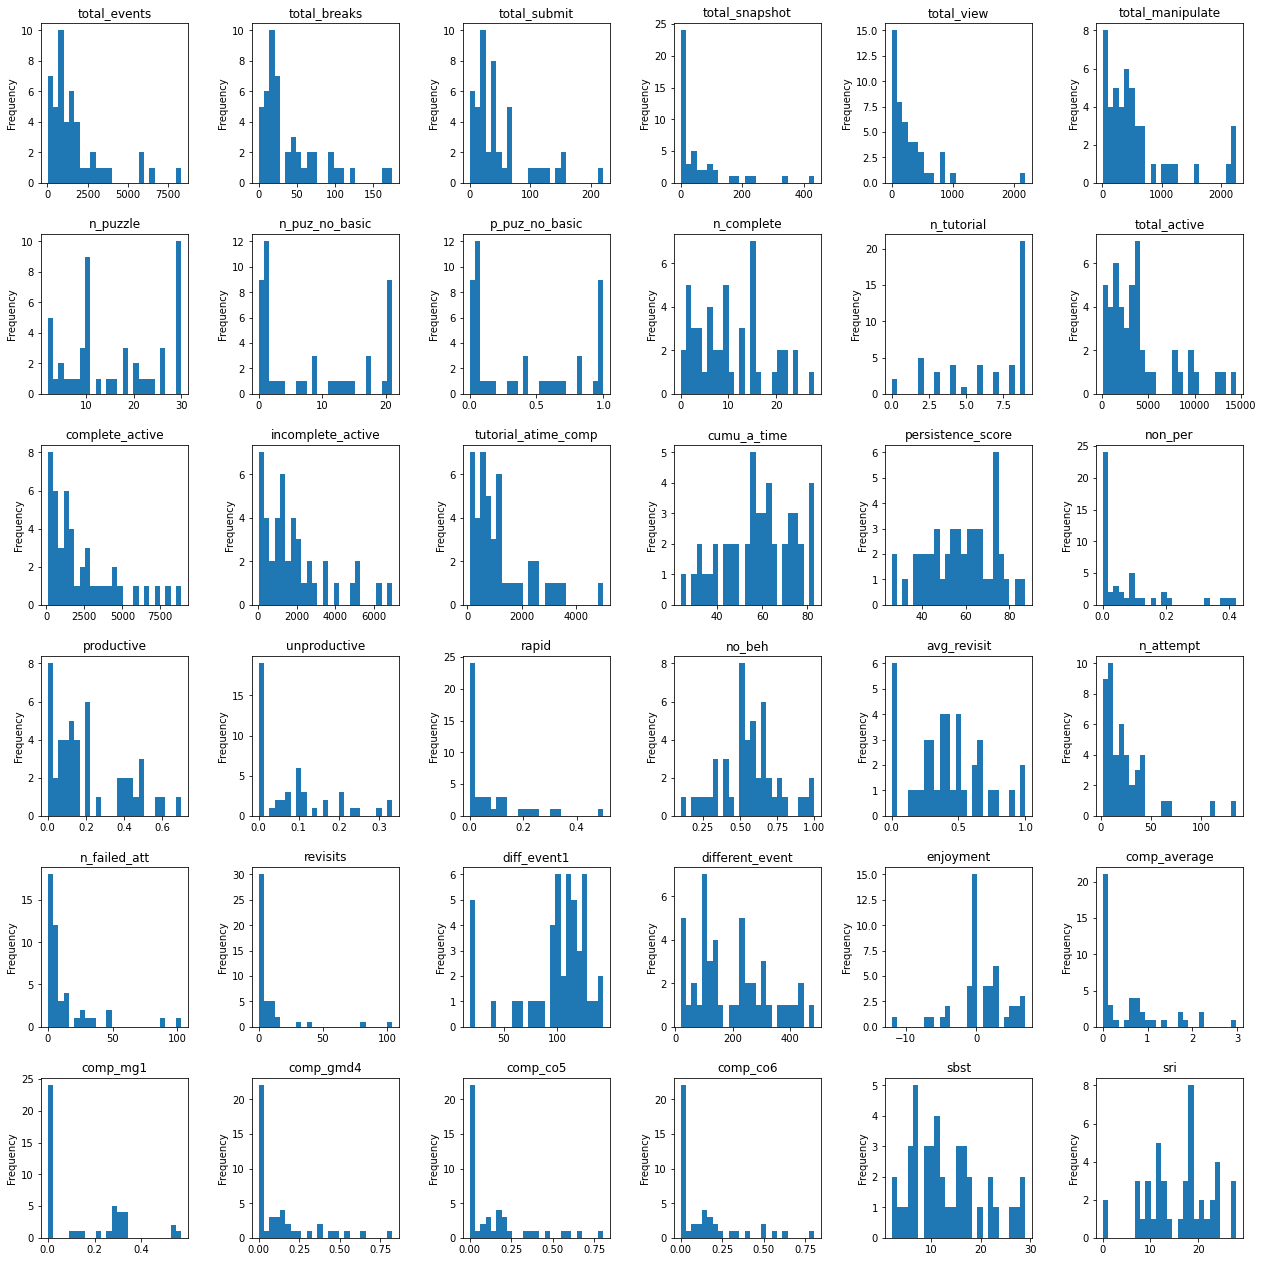

In [7]:
N = ceil(sqrt(len(features + labels)))
fig, axs = subplots(N, N)
fig.set_size_inches(3*N, 3*N)
fig.tight_layout(pad=3.0)
for i, col in enumerate(features + labels):
    data[col].plot(kind="hist", ax=axs[i//N][i%N], title=col, bins=25)

fig.savefig("output/hists.png")

## Percentages in binary categories

In [8]:
# gender
percent_female = len(data[data["gender_number"] == 1]) / len(data) * 100
print(f"Percent of students that are female: {percent_female:.4}")

# handedness
percent_left = len(data[data["hand_number"] == 1]) / len(data) * 100
print(f"Percent of students that are left-handed: {percent_left:.4}")

# handedness
percent_gamer = len(data[data["gamer_number"] == 1]) / len(data) * 100
print(f"Percent of students that are gamers: {percent_gamer:.4}")

Percent of students that are female: 51.06
Percent of students that are left-handed: 19.15
Percent of students that are gamers: 36.17


# Analysis

## Correlation

In [23]:
pw = pairwise_corr(data[features + labels + corr_extras])
pw.to_csv("output/corr.csv", sep="\t")
display(pw)

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,total_breaks,total_submit,pearson,two-sided,47,0.81080,"[0.68, 0.89]",0.00000,1.947e+09,1.00000
1,total_breaks,total_snapshot,pearson,two-sided,47,0.43005,"[0.16, 0.64]",0.00255,15.021,0.86848
2,total_breaks,total_view,pearson,two-sided,47,0.32167,"[0.04, 0.56]",0.02746,1.922,0.60744
3,total_breaks,total_manipulate,pearson,two-sided,47,0.75261,"[0.59, 0.85]",0.00000,1.22e+07,1.00000
4,total_breaks,n_puzzle,pearson,two-sided,47,0.63588,"[0.43, 0.78]",0.00000,1.3e+04,0.99892
...,...,...,...,...,...,...,...,...,...,...
698,sri,mr,pearson,two-sided,44,0.89109,"[0.81, 0.94]",0.00000,1.082e+13,1.00000
699,sri,sv,pearson,two-sided,44,0.86592,"[0.77, 0.93]",0.00000,2.203e+11,1.00000
700,so,mr,pearson,two-sided,44,0.61059,"[0.38, 0.77]",0.00001,2199.77,0.99570
701,so,sv,pearson,two-sided,44,0.61764,"[0.39, 0.77]",0.00001,2907.53,0.99654


## Cronbach's Alpha

In [10]:
alpha, _ = cronbach_alpha(data=data[["so", "mr", "sv"]])
print(f"Cronbach's Alpha for SRI facets: {alpha}")

alpha, _ = cronbach_alpha(data=data[[f"sbst{i}" for i in range(1,31)]])
print(f"Cronbach's Alpha for SBST facets: {alpha}")

Cronbach's Alpha for SRI facets: 0.8359066056875625
Cronbach's Alpha for SBST facets: 0.8990425510278549


## ANOVA

In [11]:
# SRI and gender
aov = anova(data=data, dv="sri", between="gender")
print("ANOVA of sri between gender:")
display(aov)
print()

# SBST and gender
aov = anova(data=data, dv="sbst", between="gender")
print("ANOVA of sbst between gender:")
display(aov)
print()

# n_complete and gender
aov = anova(data=data, dv="n_complete", between="gender")
print("ANOVA of n_complete between gender:")
display(aov)
print()


# SRI and hand
aov = anova(data=data, dv="sri", between="hand_number")
print("ANOVA of sri between handedness:")
display(aov)
print()

# SBST and hand
aov = anova(data=data, dv="sbst", between="hand_number")
print("ANOVA of sbst between handedness:")
display(aov)
print()

# n_complete and hand
aov = anova(data=data, dv="n_complete", between="hand_number")
print("ANOVA of n_complete between handedness:")
display(aov)
print()


# SRI and gamer
aov = anova(data=data, dv="sri", between="gamer_number")
print("ANOVA of sri between gamerness:")
display(aov)
print()

# SBST and gamer
aov = anova(data=data, dv="sbst", between="gamer_number")
print("ANOVA of sbst between gamerness:")
display(aov)
print()

# n_complete and gamer
aov = anova(data=data, dv="n_complete", between="gamer_number")
print("ANOVA of n_complete between gamerness:")
display(aov)
print()

ANOVA of sri between gender:


,Source,ddof1,ddof2,F,p-unc,np2
0,gender,1,42,1.777605,0.18963,0.040605



ANOVA of sbst between gender:


,Source,ddof1,ddof2,F,p-unc,np2
0,gender,1,39,1.834019,0.183449,0.044914



ANOVA of n_complete between gender:


,Source,ddof1,ddof2,F,p-unc,np2
0,gender,1,42,0.614792,0.437389,0.014427



ANOVA of sri between handedness:


,Source,ddof1,ddof2,F,p-unc,np2
0,hand_number,1,42,0.536977,0.467758,0.012624



ANOVA of sbst between handedness:


,Source,ddof1,ddof2,F,p-unc,np2
0,hand_number,1,39,0.184474,0.66992,0.004708



ANOVA of n_complete between handedness:


,Source,ddof1,ddof2,F,p-unc,np2
0,hand_number,1,42,1.301829,0.260344,0.030064



ANOVA of sri between gamerness:


,Source,ddof1,ddof2,F,p-unc,np2
0,gamer_number,1,26,0.156389,0.695729,0.005979



ANOVA of sbst between gamerness:


,Source,ddof1,ddof2,F,p-unc,np2
0,gamer_number,1,27,0.303893,0.585985,0.01113



ANOVA of n_complete between gamerness:


,Source,ddof1,ddof2,F,p-unc,np2
0,gamer_number,1,27,1.672019,0.206943,0.058315


## Linear Regression

In [29]:
linear_regression(data[features], data["sri"], remove_na=True, as_dataframe=True)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,58055239.20066,23.62722,2457133.28733,0.00000,0.91786,0.28128,58055173.60096,58055304.80035
1,total_breaks,0.83207,0.39707,2.09553,0.10418,0.91786,0.28128,-0.27037,1.93452
2,total_submit,-0.28787,0.12632,-2.27891,0.08489,0.91786,0.28128,-0.63858,0.06285
3,total_snapshot,-0.06809,0.04348,-1.56600,0.19241,0.91786,0.28128,-0.18881,0.05263
4,total_view,0.06966,0.03727,1.86904,0.13498,0.91786,0.28128,-0.03382,0.17315
5,total_manipulate,0.03187,0.01623,1.96336,0.12109,0.91786,0.28128,-0.01320,0.07694
6,n_puzzle,-12.31936,4.65884,-2.64430,0.05732,0.91786,0.28128,-25.25438,0.61566
7,n_puz_no_basic,2082952.16205,3.84860,541223.95423,0.00000,0.91786,0.28128,2082941.47663,2082962.84746
8,p_puz_no_basic,-43741882.58577,0.18343,-238459941.55861,0.00000,0.91786,0.28128,-43741883.09506,-43741882.07647
9,n_complete,8.99101,6.14444,1.46327,0.21723,0.91786,0.28128,-8.06870,26.05071


## Random Forest and XGB

### Helper

In [ ]:
# specify the models
label_dict = {
    label: data[data[label] > 0][everything].dropna()
    for label in labels
}

model_dict = {
    "xgb": XGBRegressor(tree_method="hist", random_state=42),
    "rf": RandomForestRegressor(n_estimators=1000, random_state=42)
}

param_dict = { # TODO
    "xgb": {},
    "rf": {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    }
}

# Helper to run all the steps for a given dependent variable and regressor
def run_regressor(m, label, features, protecteds):
    
    # Heading
    display(Markdown(f"---\n\n# {m} {label}"))
    
    # Conventional Shorthand
    model = model_dict[m]
    subdata = label_dict[label]
    X = subdata[features]
    y = subdata[label]
    
    # Hyperparameter tuning
    parameters = param_dict[m]
    search = RandomizedSearchCV(model, parameters, scoring="r2", n_iter=200, cv=2, verbose=2, random_state=42, n_jobs=-1)
    search.fit(X, y)
    display(Markdown(f"**Hyperparameters:**"))
    display(DataFrame(search.best_params_, index=[0]))
    model.set_params(**search.best_params_)
    
    # Fit model
    yhat = cross_val_predict(model, X, y, cv=2)
    model.fit(X, y)
    
    # Check goodness
    errors = abs(yhat - y)
    mae = round(mean(errors), 2)
    display(Markdown(f"**Mean Absolute Error:** {mae} degrees."))
    display(Markdown(f"**Pearson:**"))
    display(corr(yhat, y))
    display(Markdown(f"**R^2 Score:**"))
    display(r2_score(y, yhat))
    
    # Explain features
    explain = Explainer(model, X, y, verbose=False)
    explain.model_parts().plot()
    
    # Check fairness
    for col in protecteds:
        display(Markdown(f"## {col}"))
        for c in unique(X[col].values):
            display(Markdown(f"### where {col}=={c}"))
            rows = X[col] == c
            try:
                mae = round(mean(errors[rows]), 2)
                display(Markdown(f"**Mean Absolute Error:** {mae} degrees."))
                display(Markdown(f"**Pearson:**"))
                display(corr(yhat[rows], y[rows]))
                display(Markdown(f"**R^2 Score:**"))
                display(r2_score(y[rows], yhat[rows]))
            except Exception as e:
                print(f"(Unable to run a regression on {col}, there are probably not enough values in one of the test subgroups.")

### Run

In [ ]:
run_regressor("rf", "sri", features, protecteds)

In [ ]:
run_regressor("rf", "sbst", features, protecteds)

In [ ]:
# run_regressor("xgb", "sri", features, protecteds)

In [ ]:
# run_regressor("xgb", "sbst", features, protecteds)